# Прогноз количества заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План работ

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Описание данных

Данные лежат в файле `taxi.csv`.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Загрузка данных

Сперва установим и импортируем все необходимые библиотеки:

In [1]:
!pip install catboost
!pip install -U scikit-learn

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from numpy.random import RandomState
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["font.size"] = 14
state = RandomState(12345)
plt.rcParams["figure.figsize"] = [20, 10]

### Загрузка и ресемлирование

Далее загрузим данные, установим в качестве индексов колонку с датой и временем и ресемплируем данные с интервалом 1 час:

In [4]:
try:
    df = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])

except:
    df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [5]:
df.sort_index(inplace=True)
df = df.resample("1H").sum()
display(df.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выведем общую информацию про датафрейм:

In [6]:
print("Общая информация о данных:")
df.describe()

Общая информация о данных:


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Посмотрим за какой промежуток времени данные:

In [7]:
print("Начало данных: ", df.index.min())
print("Конец данных: ", df.index.max())

Начало данных:  2018-03-01 00:00:00
Конец данных:  2018-08-31 23:00:00


Имеем данные с 1 марта по 31 августа 2018 года.

### Пропуски

Проверим количество пропусков:

In [8]:
print("Количество пропусков = ", df.isnull().sum().sum())

Количество пропусков =  0


### Выбросы 

Далее оценим выбросы:

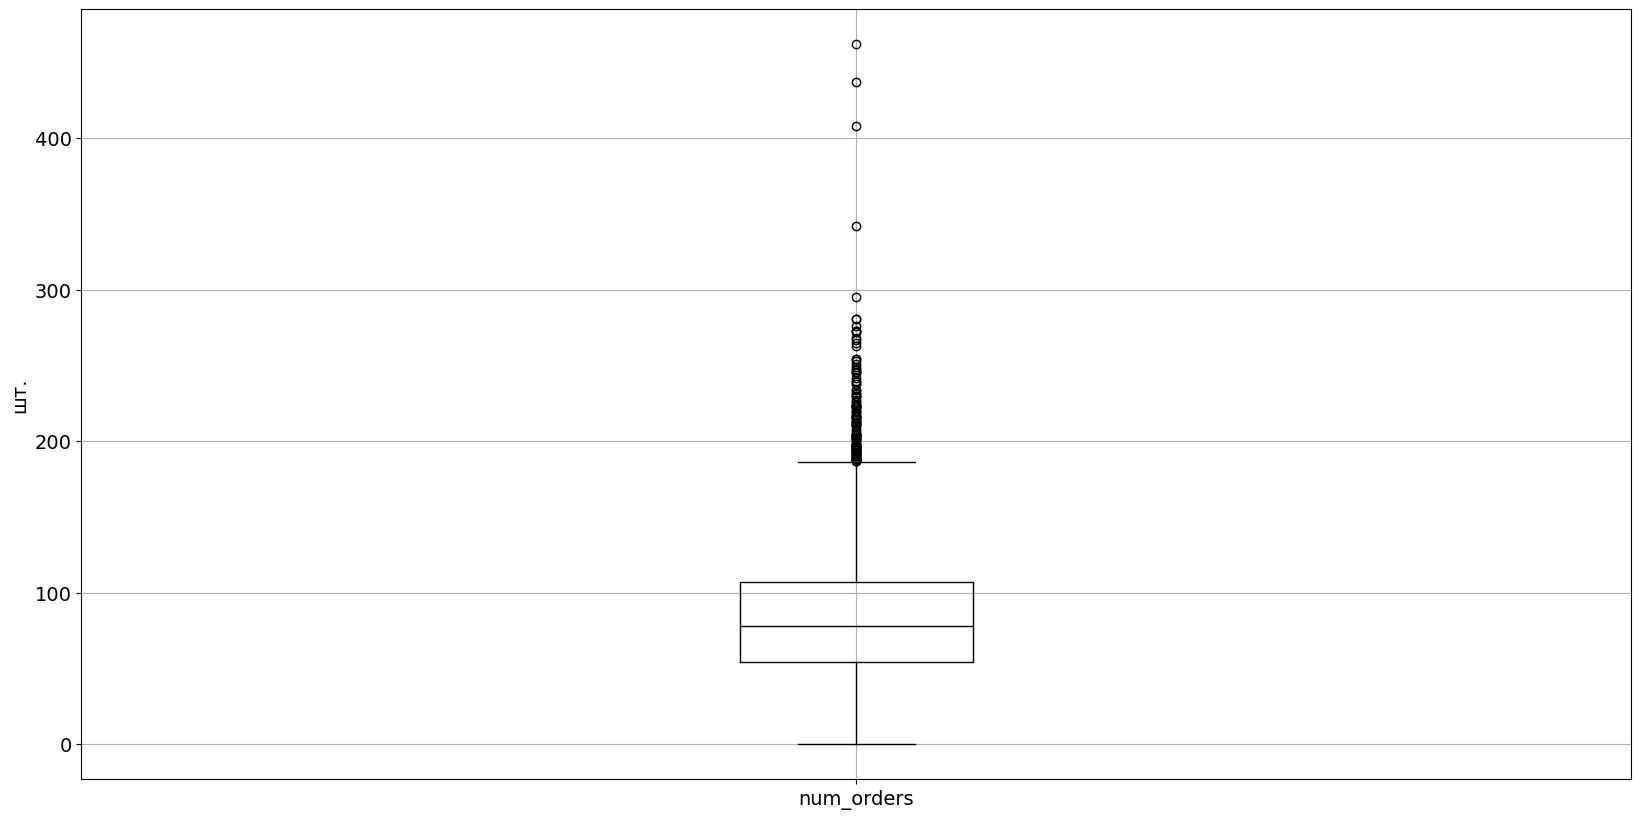

In [9]:
df.boxplot(grid=True, color="black")
plt.ylabel("шт.")
plt.show()

Удалим выбросы больше 300:

In [10]:
df = df.loc[df["num_orders"] <= 300]

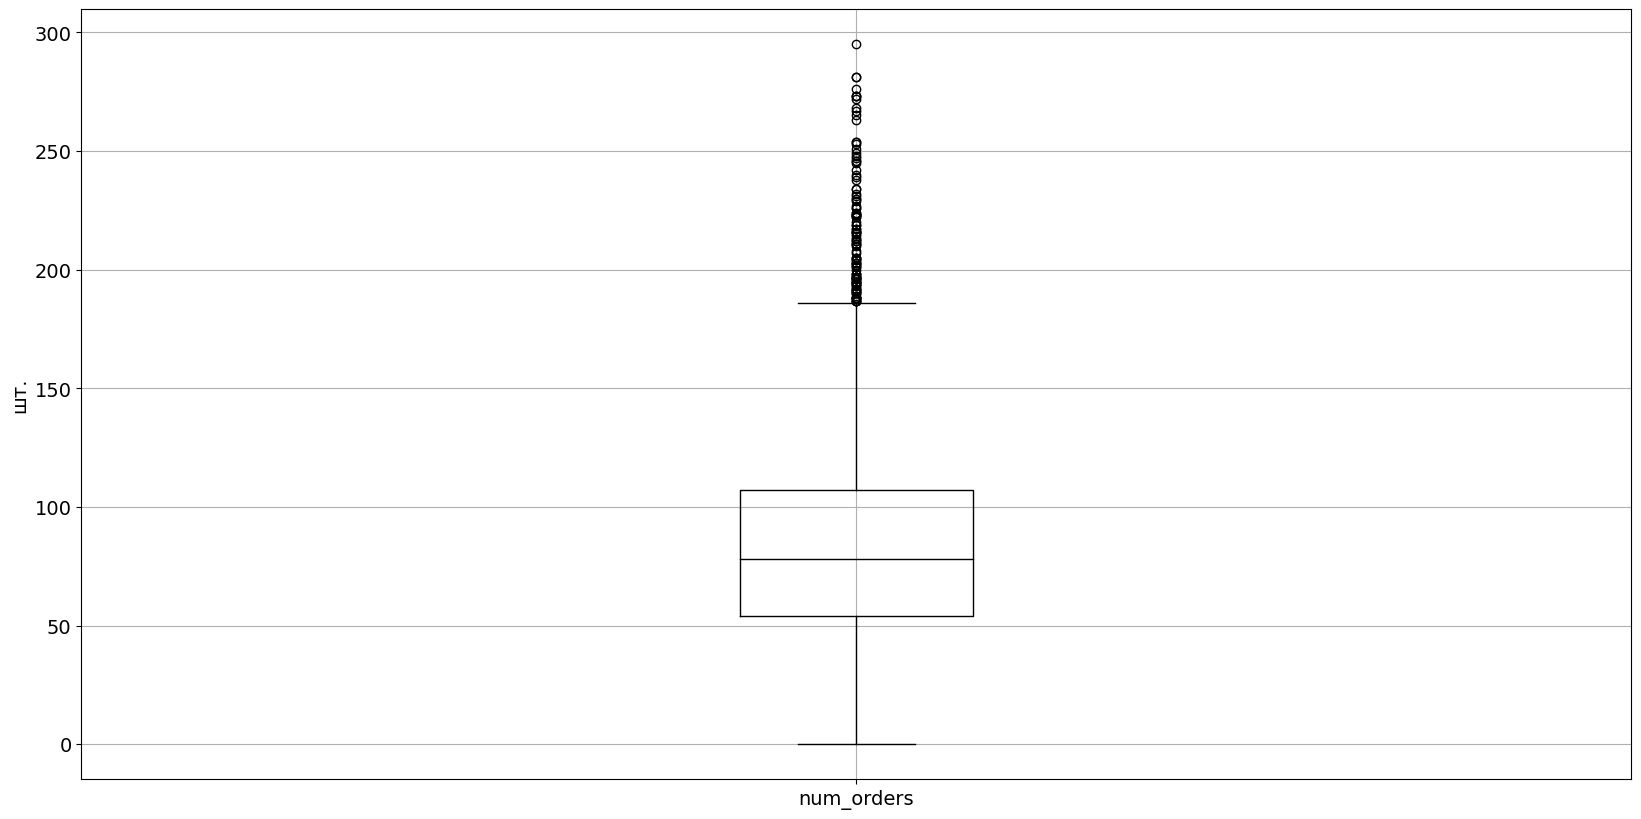

In [11]:
df.boxplot(grid=True, color="black")
plt.ylabel("шт.")
plt.show()

### Промежуточный вывод

1. Загрузили данные
2. В качестве индексов сделали колонку с датами
3. Провели ресемплирования по 1 часу
4. Убедились, что нет пропусков
5. Избавились от выбросов.

## Анализ данных

### Тренды и сезонность

Построим график зависимости количества заказов такси от времени:

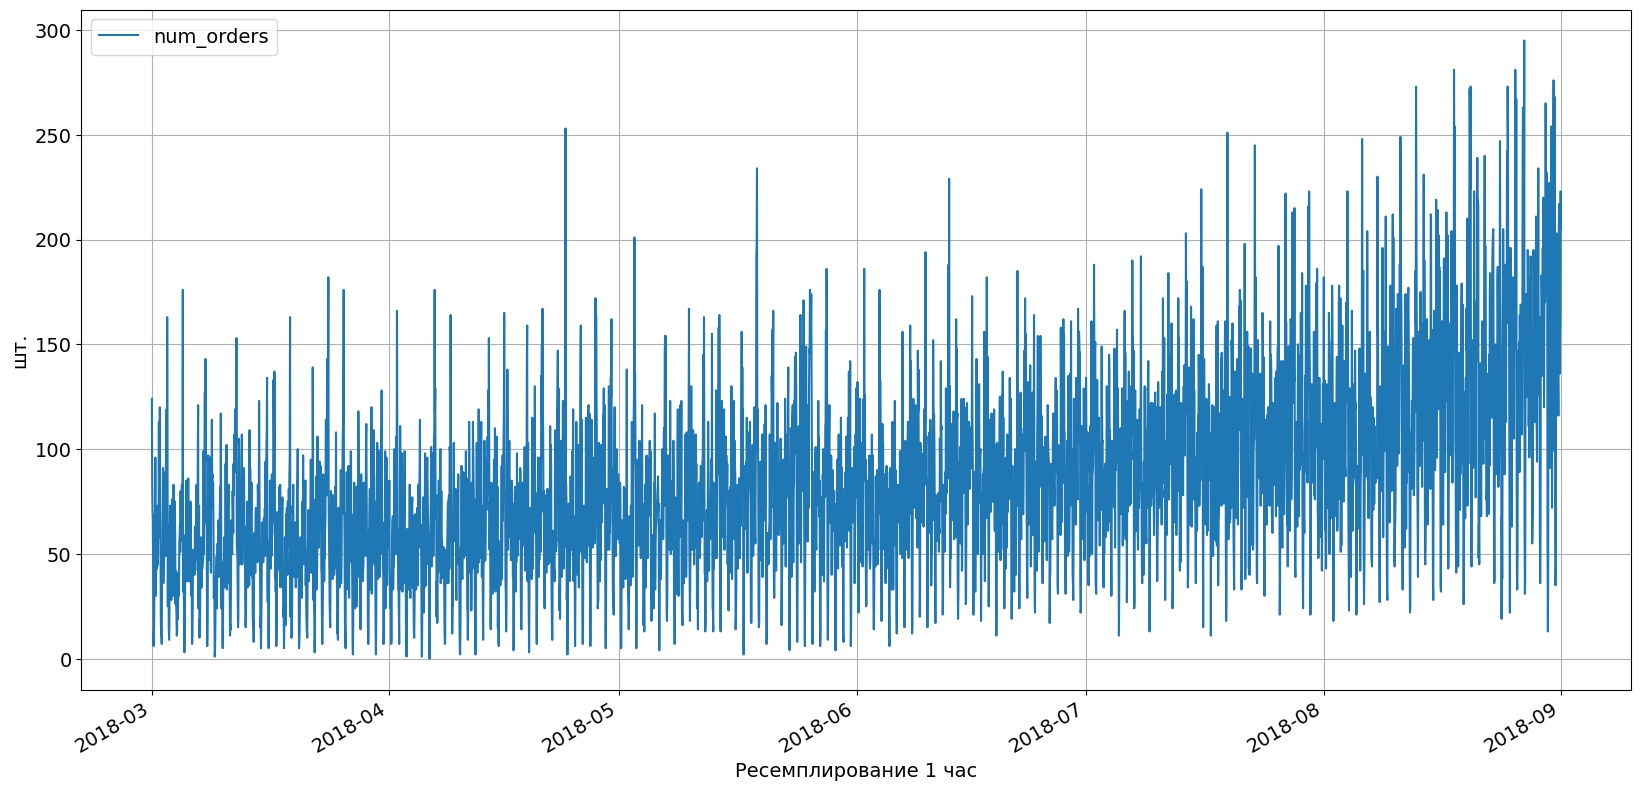

In [12]:
df.plot(grid=True)
plt.ylabel("шт.")
plt.xlabel("Дата")
plt.xlabel("Ресемплирование 1 час")
plt.show()

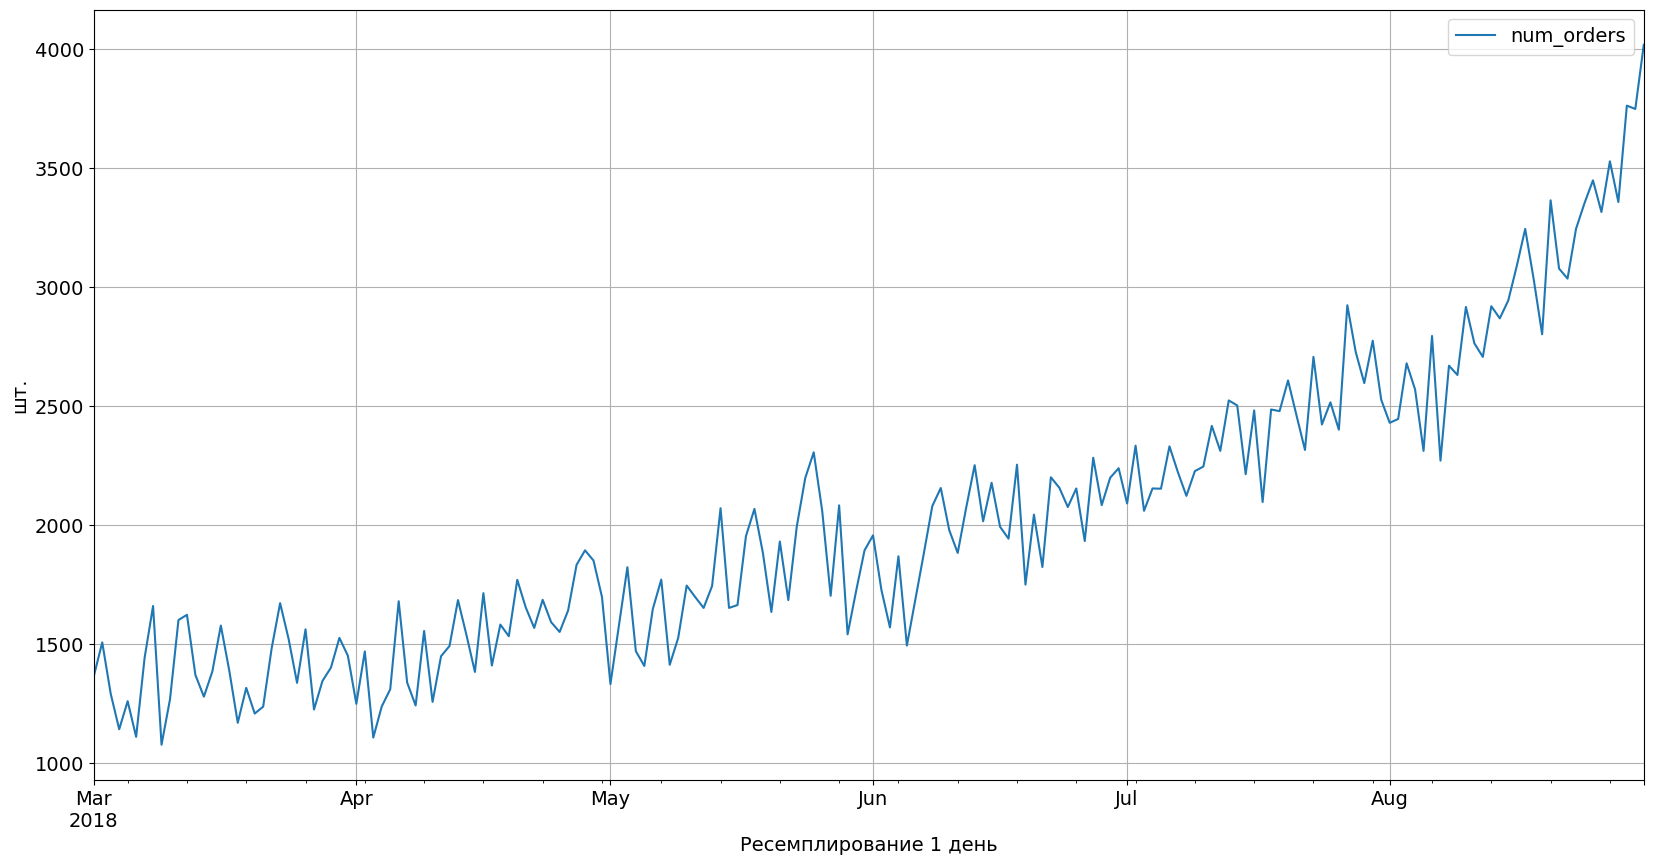

In [13]:
df.resample("1D").sum().plot(grid=True)
plt.ylabel("шт.")
plt.xlabel("Дата")
plt.xlabel("Ресемплирование 1 день")
plt.show()

Более явно выражен восходящий тренд нежели у почасово ресемплированных данных.

Далее рассмотрим тренд за весь период и сезонную составляющую данных за первую неделю апреля 2018 года :

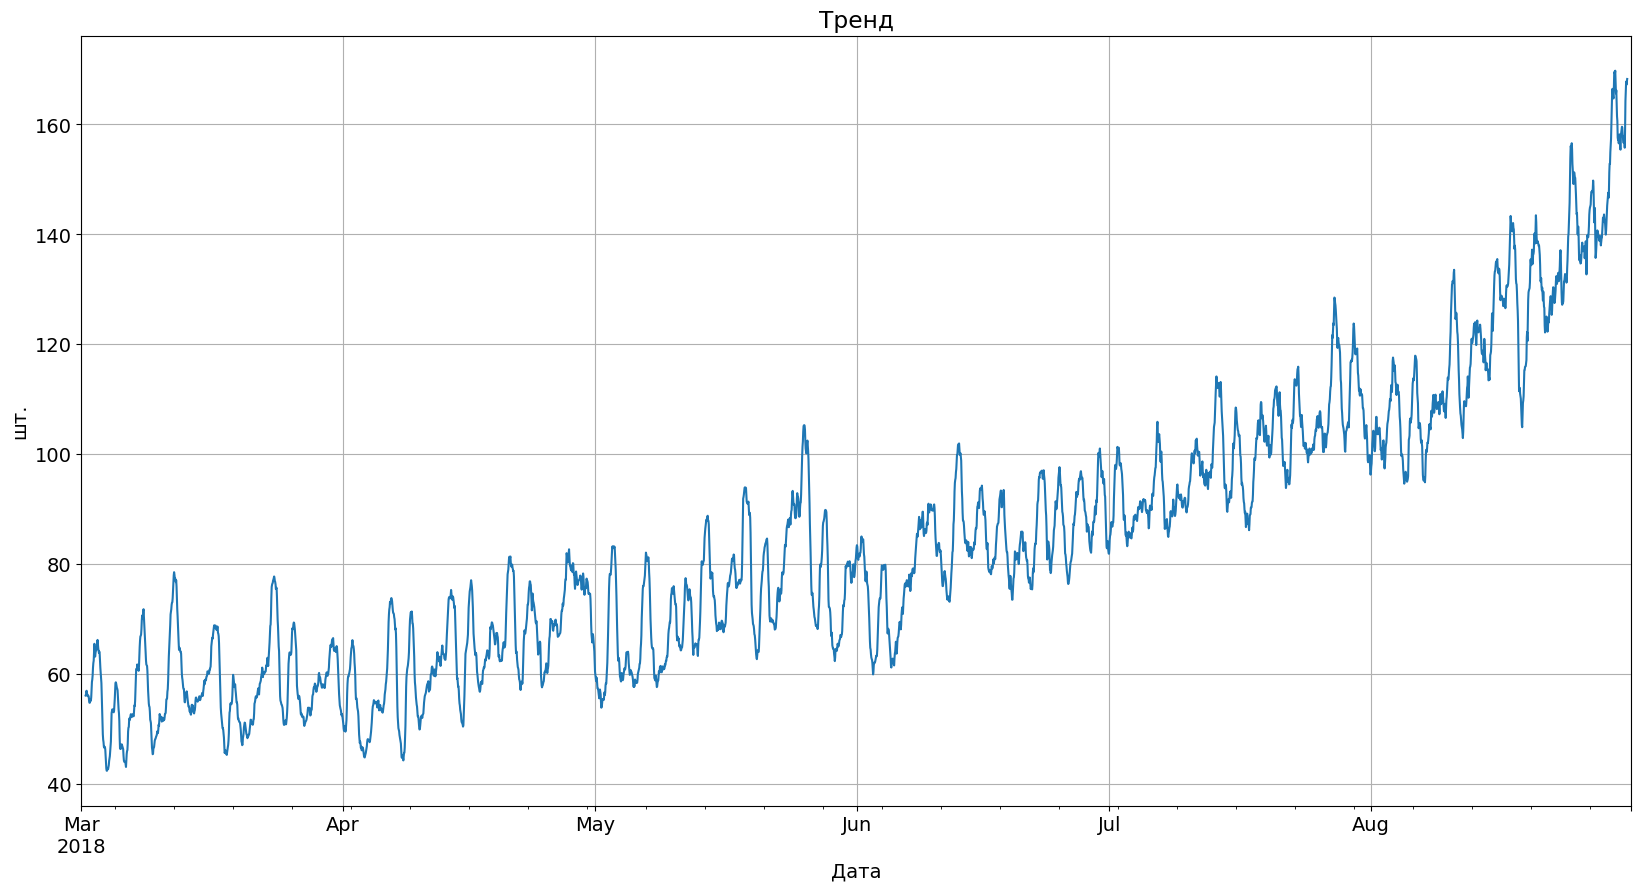

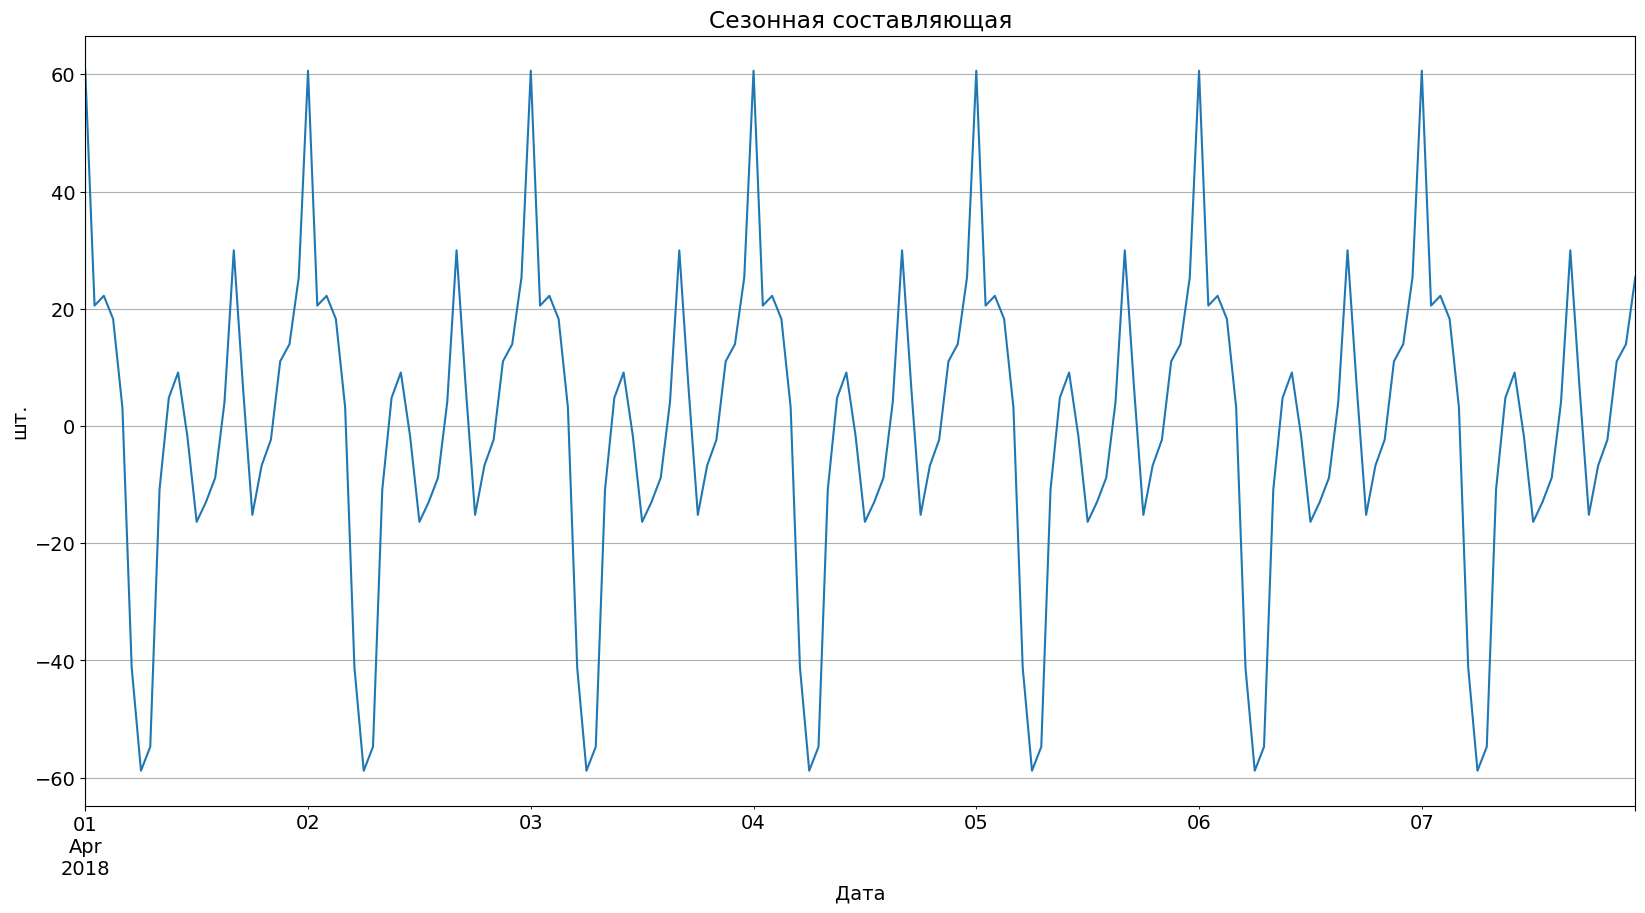

In [14]:
df = df.resample("1H").sum()
decomposed = seasonal_decompose(df)

decomposed.trend.plot(grid=True)
plt.title("Тренд")
plt.ylabel("шт.")
plt.xlabel("Дата")
plt.show()

decomposed.seasonal["2018-04-01":"2018-04-7"].plot(grid=True)
plt.title("Сезонная составляющая")
plt.ylabel("шт.")
plt.xlabel("Дата")
plt.show()

Видим, что данные имеют восходящий тренд. А периодичность - посуточная. Можно поближе посмотреть данные за сутки:

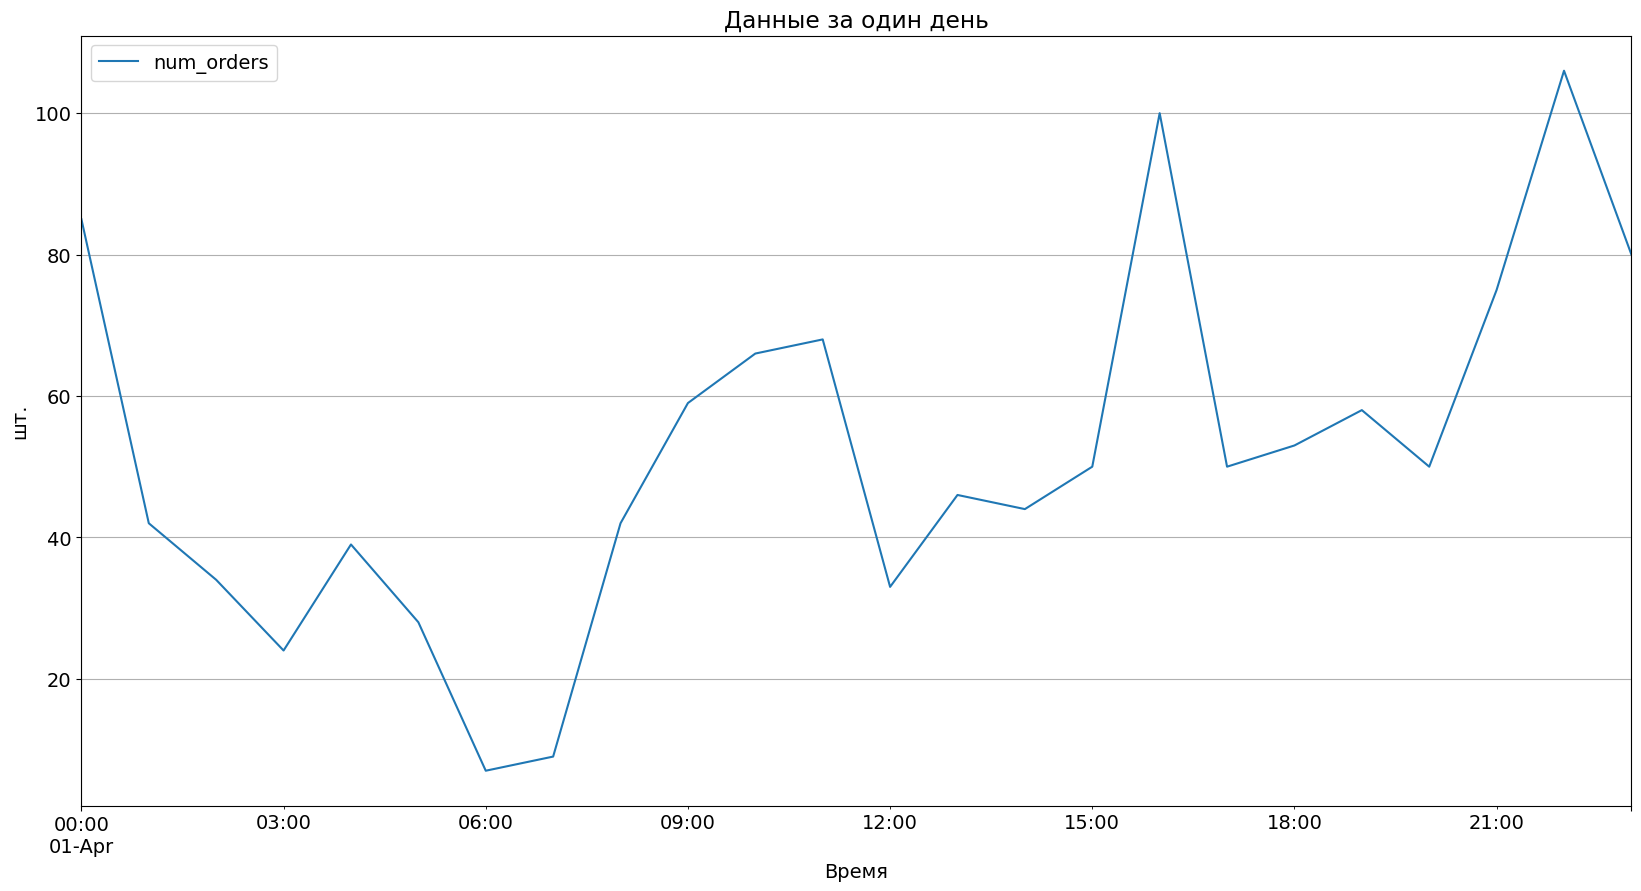

In [15]:
df["2018-04-01":"2018-04-1"].plot(grid=True)
plt.title("Данные за один день")
plt.ylabel("шт.")
plt.xlabel("Время")
plt.show()

Видим, что самое большое число заказов в час пик, когда люди едут с работы, а также ночью, наверное, потому что общественный транспорт уже не работает. Самые низкие показатели ранним утром, когда никому никуда не надо ехать.

### Стационарность

Проверим стационарны ли наши данные. Для этого найдем разности временного ряда и отобразим на графике вместе со скользящим средним и скользящим стандартным
отклонением:

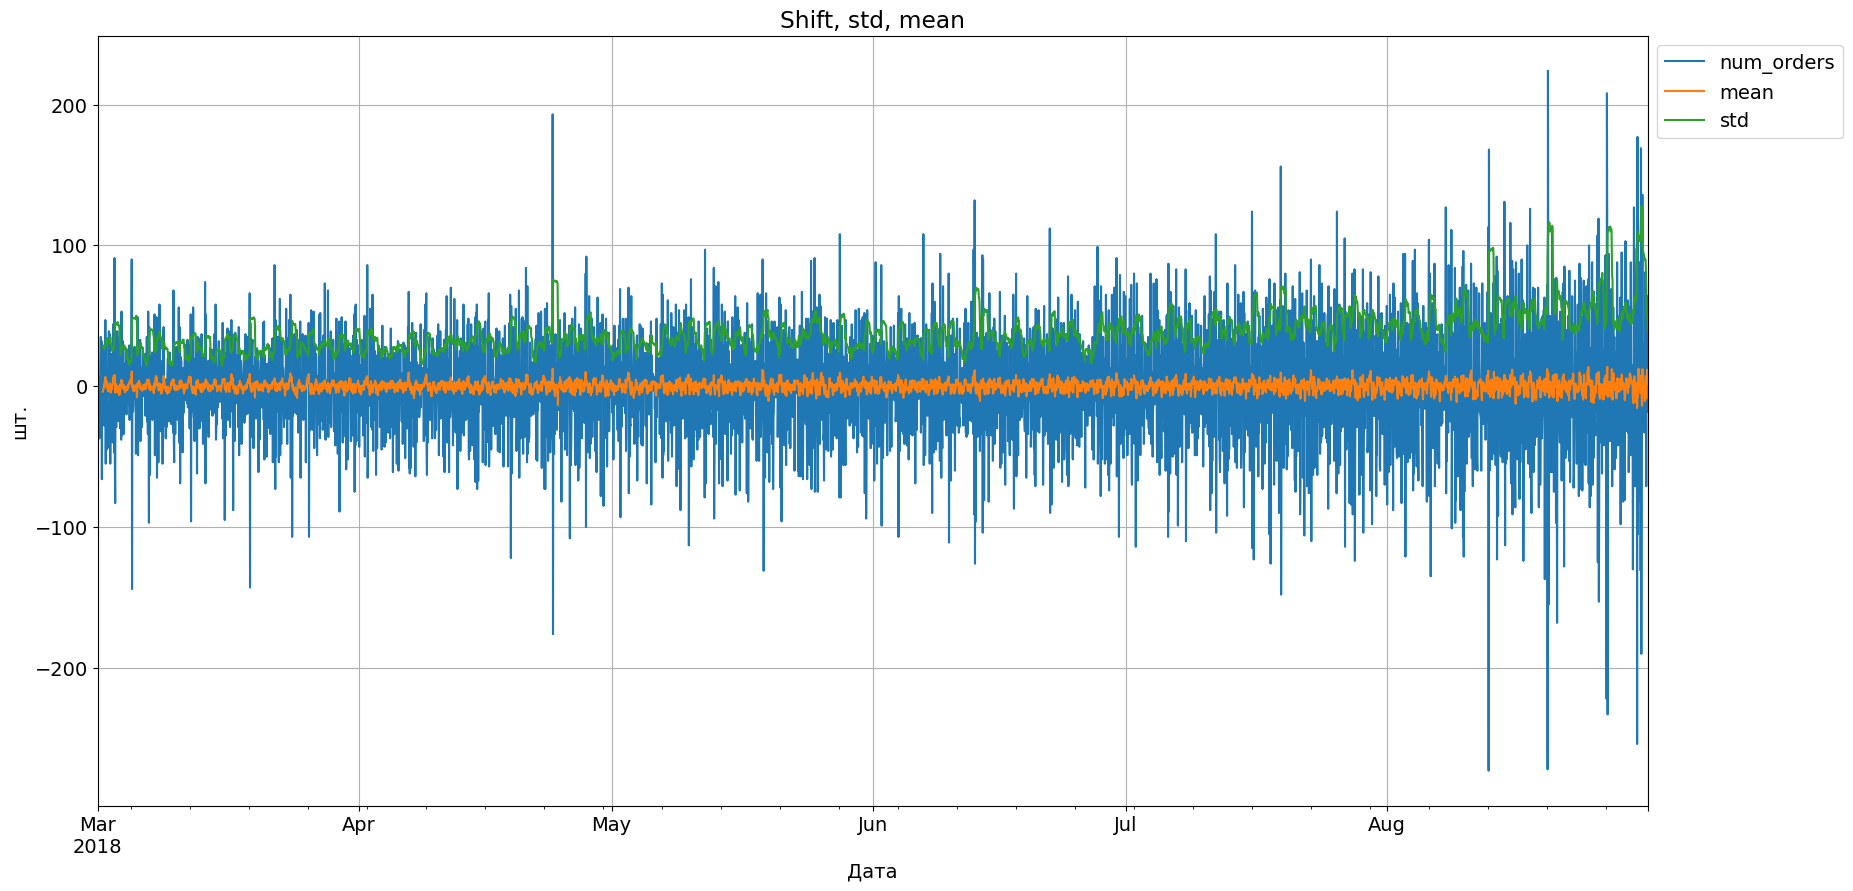

In [16]:
df_shift = df - df.shift()
df_shift["mean"] = df_shift["num_orders"].rolling(15).mean()
df_shift["std"] = df_shift["num_orders"].rolling(15).std()
df_shift.plot(grid=True)
plt.title("Shift, std, mean")
plt.ylabel("шт.")
plt.xlabel("Дата")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Видим, что среднее значение  и стандартное отклонение не сильно меняется со временем, можно считать наш временной ряд стационарным. Но тем не менее проверим стационарность с помощью теста Дики-Фуллера:

Гипотезы звучит следующим образом:

    * Нулевая - "Временной ряд является нестацинарным". 
    * Альтернативная -"Временной ряд стационарен"

In [17]:
p_value = adfuller(df)[1]
print("P =", p_value)
if p_value < 0.05:
    print("Нулевая гипотеза отвергнута. Ряд стационарен.")
else:
    print("Нулевую гипотезу отвергнуть не удалось.")

P = 0.04077296612189001
Нулевая гипотеза отвергнута. Ряд стационарен.


### Создание признаков 

Создадим функцию, которая будет для данных создавать дополнительные признаки для дальнейшего обучения моделей:

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data["day"] = data.index.day
    data["dayofweek"] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)

    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
    return data

### Промежуточный вывод

1. Рассмотрели тренд и сезонность данных:
    * **тренд** - восходящий
    * **сезонность** - посуточная
2. Максимальные количество заказов обычно ближе к 12 ночи, минимальное - в 6 утра.
3. Рассмотрели наш временной ряд на стационарность - в целом по графику можно сказать что ряд стационарный.
4. Написали функцию, которая будет создавать дополнительные признаки для обучения моделей.

## Обучение моделей

Обучим три модели:
1. Линейная регрессия 
2. Случайный лес
3. CatBoost

Сперва напишем функцию разбивающую данные на обучающую и тестовую выборки:

In [19]:
def split_and_feat(data):
    train_l, test_l = train_test_split(data, shuffle=False, test_size=0.1)
    train_l = train_l.dropna()

    train_X_l = train_l.drop("num_orders", axis=1)
    train_y_l = train_l["num_orders"]

    test_X_l = test_l.drop("num_orders", axis=1)
    test_y_l = test_l["num_orders"]

    return train_X_l, train_y_l, test_X_l, test_y_l

### Линейная регрессия

In [20]:
param_distributions = {
    "fit_intercept": [True, False],
    "copy_X": [True, False],
    "positive": [True, False],
}

best_score = 1000
for rolling_mean in tqdm(range(4, 25, 4)):
    for lag in range(4, 25, 4):
        df_feature = make_features(df, lag, rolling_mean)

        X_train, y_train, X_test, y_test = split_and_feat(df_feature)

        scaler_linear_regression = StandardScaler()
        scaler_linear_regression.fit(X_train)
        X_train = scaler_linear_regression.transform(X_train)

        model_linear_regression = LinearRegression()
        ts_cv = TimeSeriesSplit(n_splits=3)
        linear_regression = GridSearchCV(
            estimator=model_linear_regression,
            param_grid=param_distributions,
            verbose=0,
            cv=ts_cv,
            n_jobs=-1,
            scoring="neg_root_mean_squared_error",
        ).fit(X_train, y_train)

        if abs(linear_regression.best_score_) < best_score:
            best_score = abs(linear_regression.best_score_)

            X_test_linear_regression = X_test
            y_test_linear_regression = y_test

            linear_regression_best = linear_regression

            print("lag = ", lag)
            print("rolling_mean_size = ", rolling_mean)
            print(linear_regression.best_params_)
            print()
            print("Лучшее значение RMSE = ", best_score)
            print("===============================")

  0%|          | 0/6 [00:00<?, ?it/s]

lag =  4
rolling_mean_size =  4
{'copy_X': True, 'fit_intercept': True, 'positive': True}

Лучшее значение RMSE =  33.797370730885255
lag =  8
rolling_mean_size =  4
{'copy_X': True, 'fit_intercept': True, 'positive': True}

Лучшее значение RMSE =  33.482361434980454
lag =  12
rolling_mean_size =  4
{'copy_X': True, 'fit_intercept': True, 'positive': True}

Лучшее значение RMSE =  33.089224223724706
lag =  16
rolling_mean_size =  4
{'copy_X': True, 'fit_intercept': True, 'positive': True}

Лучшее значение RMSE =  32.94555519990711


 17%|█▋        | 1/6 [00:02<00:14,  2.82s/it]

lag =  24
rolling_mean_size =  4
{'copy_X': True, 'fit_intercept': True, 'positive': True}

Лучшее значение RMSE =  27.597075520799255


100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Выяснили лучшие гиперпараметры для линейной регрессии, параметры для создания признаков "Отстающие значения" и "Скользящее среднее".

### Случайный лес

In [21]:
param_distributions = {
    "max_depth": [5, 20],
    "n_estimators": [2, 10],
}

best_score = 1000
for rolling_mean in tqdm(range(4, 25, 4)):
    for lag in range(4, 25, 4):
        df_feature = make_features(df, lag, rolling_mean)

        X_train, y_train, X_test, y_test = split_and_feat(df_feature)

        # scaler_RandomForestRegressor = StandardScaler()
        # scaler_RandomForestRegressor.fit(X_train)
        # X_train = scaler_RandomForestRegressor.transform(X_train)

        model_RandomForestRegressor = RandomForestRegressor(random_state=state)
        ts_cv = TimeSeriesSplit(n_splits=3)
        random_forest_regressor = GridSearchCV(
            estimator=model_RandomForestRegressor,
            param_grid=param_distributions,
            verbose=0,
            n_jobs=-1,
            cv = ts_cv,
            scoring="neg_root_mean_squared_error",
        ).fit(X_train, y_train)

        if abs(random_forest_regressor.best_score_) < best_score:
            best_score = abs(random_forest_regressor.best_score_)

            X_test_RandomForestRegressor = X_test
            y_test_RandomForestRegressor = y_test

            random_forest_regressor_best = random_forest_regressor

            print("lag = ", lag)
            print("rolling_mean_size = ", rolling_mean)
            print(random_forest_regressor.best_params_)
            print()
            print("Лучшее значение RMSE = ", best_score)
            print("===============================")

  0%|          | 0/6 [00:00<?, ?it/s]

lag =  4
rolling_mean_size =  4
{'max_depth': 20, 'n_estimators': 10}

Лучшее значение RMSE =  28.41963095481775


100%|██████████| 6/6 [00:35<00:00,  5.94s/it]


Выяснили лучшие гиперпараметры для случайного леса, параметры для создания признаков "Отстающие значения" и "Скользящее среднее".

### CatBoost

In [22]:
param_distributions = {
    "learning_rate": [0.03, 0.7],
    "iterations": [50, 200],
}

best_score = 1000
for rolling_mean in tqdm(range(4, 25, 4)):
    for lag in range(4, 25, 4):
        df_feature = make_features(df, lag, rolling_mean)

        X_train, y_train, X_test_CatBoost, y_test_CatBoost = split_and_feat(df_feature)

        scaler_CatBoost = StandardScaler()
        scaler_CatBoost.fit(X_train)
        X_train = scaler_CatBoost.transform(X_train)
    
        model_CatBoost = CatBoostRegressor(
            task_type="GPU",
            loss_function="RMSE",
        )
        ts_cv = TimeSeriesSplit(n_splits=3)
        CatBoost = GridSearchCV(
            estimator=model_CatBoost,
            param_grid=param_distributions,
            verbose=0,
            cv = ts_cv,
            scoring="neg_root_mean_squared_error",
        ).fit(X_train, y_train, silent=True)

        if abs(CatBoost.best_score_) < best_score:
            best_score = abs(CatBoost.best_score_)

            X_test_CatBoost = X_test
            y_test_CatBoost = y_test

            CatBoost_best = CatBoost
            print("lag = ", lag)
            print("rolling_mean_size = ", rolling_mean)
            print(CatBoost.best_params_)
            print()
            print("Лучшее значение RMSE = ", best_score)
            print("===============================")

  0%|          | 0/6 [00:00<?, ?it/s]

lag =  4
rolling_mean_size =  4
{'iterations': 200, 'learning_rate': 0.03}

Лучшее значение RMSE =  26.872621129362994


 17%|█▋        | 1/6 [00:41<03:25, 41.13s/it]

lag =  4
rolling_mean_size =  8
{'iterations': 200, 'learning_rate': 0.03}

Лучшее значение RMSE =  26.643461863701265


100%|██████████| 6/6 [04:07<00:00, 41.27s/it]


### Промежуточный итог

1. Написали функцию для разбиения данных на обучающую и тестовую выборку
2. Обучили следующие модели и получили следующие значения ***RMSE***:
    * Линейная регрессия - 27.597
    * Случайный лес - 28.42
    * CatBoost - 26.643

## Проверка моделей на тестовой выборке

### Линейная регрессия

In [23]:
X_test_linear_regression = scaler_linear_regression.transform(X_test_linear_regression)
print(
    "RMSE:",
    mean_squared_error(
        y_test_linear_regression,
        linear_regression_best.predict(X_test_linear_regression),
        squared=False,
    ),
)

RMSE: 42.82743097223665


### Случайный лес

In [24]:
# X_test_RandomForestRegressor = scaler_RandomForestRegressor.transform(
#    X_test_RandomForestRegressor
# )
print(
    "RMSE:",
    mean_squared_error(
        y_test_RandomForestRegressor,
        random_forest_regressor_best.best_estimator_.predict(
            X_test_RandomForestRegressor
        ),
        squared=False,
    ),
)

RMSE: 45.77074837821832


### CatBoost

In [25]:
X_test_CatBoost = scaler_CatBoost.transform(X_test_CatBoost)
print(
    "RMSE:",
    mean_squared_error(
        y_test_CatBoost,
        CatBoost.best_estimator_.predict(X_test_CatBoost),
        squared=False,
    ),
)

RMSE: 45.588951539213994


## Итоговой вывод

1. Загрузка данных:
    * Загрузили данные и ресемплировали по 1 часу
    * Убедились, что нет выбросов и пропусков
2. Анализ данных:
    * Выяснили, что данные имеют восходящий тренд и сезонность равную 24 часам
    * Максимальные количество заказов обычно ближе к 12 ночи, минимальное - в 6 утра
    * Установили, что ряд стационарный, значит можно по нему делать прогнозы
3. Обучили три модели:
    * Линейная регрессия - 27.597
    * Случайный лес - 28.42
    * CatBoost - 26.643  
4. Проверили модели на тестовой выборке, у каждой модели значение RMSE получилось ниже целевого значения 48:
    * Линейная регрессия - 42.827
    * Случайный лес - 45.771
    * CatBoost - 45.589
    
Лучший результат показала модель ***Линейной регрессии***